# ME314 Homework 5

### Submission instructions

Deliverables that should be included with your submission are shown in **bold** at the end of each problem statement and the corresponding supplemental material. **Your homework will be graded IFF you submit a single PDF, .mp4 videos of animations when requested and a link to a Google colab file that meet all the requirements outlined below.**

- List the names of students you've collaborated with on this homework assignment.
- Include all of your code (and handwritten solutions when applicable) used to complete the problems.
- Highlight your answers (i.e. **bold** and outline the answers) for handwritten or markdown questions and include simplified code outputs (e.g. .simplify()) for python questions.
- Enable Google Colab permission for editing 
 * Click Share in the upper right corner
 * Under "Get Link" click "Share with..." or "Change" 
 * Then make sure it says "Anyone with Link" and "Editor" under the dropdown menu
- Make sure all cells are run before submitting (i.e. check the permission by running your code in a private mode)
 * Please don't make changes to your file after submitting, so we can grade it!
- Submit a link to your Google Colab file that has been run (before the submission deadline) and don't edit it afterwards!

**NOTE:** This Juputer Notebook file serves as a template for you to start homework. Make sure you first copy this template to your own Google driver (click "File" -> "Save a copy in Drive"), and then start to edit it.

In [33]:
#Import cell
import sympy as sym
import numpy as np
import matplotlib.pyplot as plt


In [2]:
##############################################################################################
# If you're using Google Colab, uncomment this section by selecting the whole section and press
# ctrl+'/' on your and keyboard. Run it before you start programming, this will enable the nice 
# LaTeX "display()" function for you. If you're using the local Jupyter environment, leave it alone
##############################################################################################
# def custom_latex_printer(exp,**options):
#     from google.colab.output._publish import javascript
#     url = "https://cdnjs.cloudflare.com/ajax/libs/mathjax/3.1.1/latest.js?config=TeX-AMS_HTML"
#     javascript(url=url)
#     return sym.printing.latex(exp,**options)
# sym.init_printing(use_latex="mathjax",latex_printer=custom_latex_printer)

Below are the help functions in previous homeworks, which you may need for this homework.

In [24]:
def compute_EL(lagrangian, q):
    '''
    Helper function for computing the Euler-Lagrange equations for a given system,
    so I don't have to keep writing it out over and over again.
    
    Inputs:
    - lagrangian: our Lagrangian function in symbolic (Sympy) form
    - q: our state vector [x1, x2, ...], in symbolic (Sympy) form
    
    Outputs:
    - eqn: the Euler-Lagrange equations in Sympy form
    '''
    
    # wrap system states into one vector (in SymPy would be Matrix)
    #q = sym.Matrix([x1, x2])
    qd = q.diff(t)
    qdd = qd.diff(t)

    # compute derivative wrt a vector, method 1
    # wrap the expression into a SymPy Matrix
    L_mat = sym.Matrix([lagrangian])
    dL_dq = L_mat.jacobian(q)
    dL_dqdot = L_mat.jacobian(qd)

    #set up the Euler-Lagrange equations
    LHS = dL_dq - dL_dqdot.diff(t)
    RHS = sym.zeros(len(q),1)
    eqn = sym.Eq(LHS.T, RHS.T)
    
    return eqn

def solve_EL(eqn, var):
    '''
    Helper function to solve and display the solution for the Euler-Lagrange
    equations.
    
    Inputs:
    - eqn: Euler-Lagrange equation (type: Sympy Equation())
    - var: state vector (type: Sympy Matrix). typically a form of q-doubledot
        but may have different terms
    
    Outputs:
    - Prints symbolic solutions
    - Returns symbolic solutions in a dictionary
    '''
    
    soln = sym.solve(eqn, var, dict = True)
    eqns_solved = []
    
    
    for i, sol in enumerate(soln):
        for x in list(sol.keys()):
            eqn_solved = sym.Eq(x, sol[x])
            eqns_solved.append(eqn_solved)
            
    return eqns_solved

def solve_constrained_EL(lamb, phi, q, lhs):
    """Now uses just the LHS of the constrained E-L equations,
    rather than the full equation form"""
    
    qd = q.diff(t)
    qdd = qd.diff(t)
    
    phidd = phi.diff(t).diff(t)
    lamb_grad = sym.Matrix([lamb * phi.diff(a) for a in q])
    q_mod = qdd.row_insert(2, sym.Matrix([lamb]))
    
    #format equations so they're all in one matrix
    expr_matrix = lhs - lamb_grad
    phidd_matrix = sym.Matrix([phidd])
    expr_matrix = expr_matrix.row_insert(2,phidd_matrix)
    
    print("Equations to be solved (LHS - lambda * grad(phi) = 0):")
    RHS = sym.zeros(len(expr_matrix), 1)
    disp_eq = sym.Eq(expr_matrix, RHS)
    display(disp_eq)
    print("Variables to solve for:")
    display(q_mod)

    #solve E-L equations
    eqns_solved = solve_EL(expr_matrix, q_mod)
    return eqns_solved


In [46]:
def rk4(dxdt, x, t, dt):
    '''
    Applies the Runge-Kutta method, 4th order, to a sample function,
    for a given state q0, for a given step size. Currently only
    configured for a 2-variable dependent system (x,y).
    ==========
    dxdt: a Sympy function that specifies the derivative of the system of interest
    t: the current timestep of the simulation
    x: current value of the state vector
    dt: the amount to increment by for Runge-Kutta
    ======
    returns:
    x_new: value of the state vector at the next timestep
    '''      
    k1 = dt * dxdt(t, x)
    k2 = dt * dxdt(t + dt/2.0, x + k1/2.0)
    k3 = dt * dxdt(t + dt/2.0, x + k2/2.0)
    k4 = dt * dxdt(t + dt, x + k3)
    x_new = x + (k1 + 2.0*k2 + 2.0*k3 + k4)/6.0
    
    return x_new


def simulate(f, x0, tspan, dt, integrate):
    """
    This function takes in an initial condition x0, a timestep dt,
    a time span tspan consisting of a list [min_time, max_time],
    as well as a dynamical system f(x) that outputs a vector of the
    same dimension as x0. It outputs a full trajectory simulated
    over the time span of dimensions (xvec_size, time_vec_size).
    
    Parameters
    ============
    f: Python function
        derivate of the system at a given step x(t), 
        it can considered as \dot{x}(t) = func(x(t))
    x0: NumPy array
        initial conditions
    tspan: Python list
        tspan = [min_time, max_time], it defines the start and end
        time of simulation
    dt:
        time step for numerical integration
    integrate: Python function
        numerical integration method used in this simulation

    Return
    ============
    x_traj:
        simulated trajectory of x(t) from t=0 to tf
    """
    N = int((max(tspan)-min(tspan))/dt)
    x = np.copy(x0)
    tvec = np.linspace(min(tspan),max(tspan),N)
    xtraj = np.zeros((len(x0),N))
    
    for i in range(N):
        t = tvec[i]
        xtraj[:,i]=integrate(f,x,t,dt)
        x = np.copy(xtraj[:,i])
    return xtraj 
      

In [47]:
# def integrate(f, xt, dt):
#     """
#     This function takes in an initial condition x(t) and a timestep dt,
#     as well as a dynamical system f(x) that outputs a vector of the
#     same dimension as x(t). It outputs a vector x(t+dt) at the future
#     time step.
    
#     Parameters
#     ============
#     dyn: Python function
#         derivate of the system at a given step x(t), 
#         it can considered as \dot{x}(t) = func(x(t))
#     xt: NumPy array
#         current step x(t)
#     dt: 
#         step size for integration

#     Return
#     ============
#     new_xt: 
#         value of x(t+dt) integrated from x(t)
#     """
#     k1 = dt * f(xt)
#     k2 = dt * f(xt+k1/2.)
#     k3 = dt * f(xt+k2/2.)
#     k4 = dt * f(xt+k3)
#     new_xt = xt + (1/6.) * (k1+2.0*k2+2.0*k3+k4)
#     return new_xt

# def simulate(f, x0, tspan, dt, integrate):
#     """
#     This function takes in an initial condition x0, a timestep dt,
#     a time span tspan consisting of a list [min_time, max_time],
#     as well as a dynamical system f(x) that outputs a vector of the
#     same dimension as x0. It outputs a full trajectory simulated
#     over the time span of dimensions (xvec_size, time_vec_size).
    
#     Parameters
#     ============
#     f: Python function
#         derivate of the system at a given step x(t), 
#         it can considered as \dot{x}(t) = func(x(t))
#     x0: NumPy array
#         initial conditions
#     tspan: Python list
#         tspan = [min_time, max_time], it defines the start and end
#         time of simulation
#     dt:
#         time step for numerical integration
#     integrate: Python function
#         numerical integration method used in this simulation

#     Return
#     ============
#     x_traj:
#         simulated trajectory of x(t) from t=0 to tf
#     """
#     N = int((max(tspan)-min(tspan))/dt)
#     x = np.copy(x0)
#     tvec = np.linspace(min(tspan),max(tspan),N)
#     xtraj = np.zeros((len(x0),N))
#     for i in range(N):
#         xtraj[:,i]=integrate(f,x,dt)
#         x = np.copy(xtraj[:,i])
#     return xtraj 

In [48]:
def animate_double_pend(theta_array,L1=1,L2=1,T=10):
    """
    Function to generate web-based animation of double-pendulum system

    Parameters:
    ================================================
    theta_array:
        trajectory of theta1 and theta2, should be a NumPy array with
        shape of (2,N)
    L1:
        length of the first pendulum
    L2:
        length of the second pendulum
    T:
        length/seconds of animation duration

    Returns: None
    """

    ################################
    # Imports required for animation.
    from plotly.offline import init_notebook_mode, iplot
    from IPython.display import display, HTML
    import plotly.graph_objects as go

    #######################
    # Browser configuration.
    def configure_plotly_browser_state():
        import IPython
        display(IPython.core.display.HTML('''
            <script src="/static/components/requirejs/require.js"></script>
            <script>
              requirejs.config({
                paths: {
                  base: '/static/base',
                  plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
                },
              });
            </script>
            '''))
    configure_plotly_browser_state()
    init_notebook_mode(connected=False)

    ###############################################
    # Getting data from pendulum angle trajectories.
    xx1=L1*np.sin(theta_array[0])
    yy1=-L1*np.cos(theta_array[0])
    xx2=xx1+L2*np.sin(theta_array[0]+theta_array[1])
    yy2=yy1-L2*np.cos(theta_array[0]+theta_array[1])
    N = len(theta_array[0]) # Need this for specifying length of simulation

    ####################################
    # Using these to specify axis limits.
    xm=np.min(xx1)-0.5
    xM=np.max(xx1)+0.5
    ym=np.min(yy1)-2.5
    yM=np.max(yy1)+1.5

    ###########################
    # Defining data dictionary.
    # Trajectories are here.
    data=[dict(x=xx1, y=yy1, 
               mode='lines', name='Arm', 
               line=dict(width=2, color='blue')
              ),
          dict(x=xx1, y=yy1, 
               mode='lines', name='Mass 1',
               line=dict(width=2, color='purple')
              ),
          dict(x=xx2, y=yy2, 
               mode='lines', name='Mass 2',
               line=dict(width=2, color='green')
              ),
          dict(x=xx1, y=yy1, 
               mode='markers', name='Pendulum 1 Traj', 
               marker=dict(color="purple", size=2)
              ),
          dict(x=xx2, y=yy2, 
               mode='markers', name='Pendulum 2 Traj', 
               marker=dict(color="green", size=2)
              ),
        ]

    ################################
    # Preparing simulation layout.
    # Title and axis ranges are here.
    layout=dict(xaxis=dict(range=[xm, xM], autorange=False, zeroline=False,dtick=1),
                yaxis=dict(range=[ym, yM], autorange=False, zeroline=False,scaleanchor = "x",dtick=1),
                title='Double Pendulum Simulation', 
                hovermode='closest',
                updatemenus= [{'type': 'buttons',
                               'buttons': [{'label': 'Play','method': 'animate',
                                            'args': [None, {'frame': {'duration': T, 'redraw': False}}]},
                                           {'args': [[None], {'frame': {'duration': T, 'redraw': False}, 'mode': 'immediate',
                                            'transition': {'duration': 0}}],'label': 'Pause','method': 'animate'}
                                          ]
                              }]
               )

    ########################################
    # Defining the frames of the simulation.
    # This is what draws the lines from
    # joint to joint of the pendulum.
    frames=[dict(data=[dict(x=[0,xx1[k],xx2[k]], 
                            y=[0,yy1[k],yy2[k]], 
                            mode='lines',
                            line=dict(color='red', width=3)
                            ),
                       go.Scatter(
                            x=[xx1[k]],
                            y=[yy1[k]],
                            mode="markers",
                            marker=dict(color="blue", size=12)),
                       go.Scatter(
                            x=[xx2[k]],
                            y=[yy2[k]],
                            mode="markers",
                            marker=dict(color="blue", size=12)),
                      ]) for k in range(N)]

    #######################################
    # Putting it all together and plotting.
    figure1=dict(data=data, layout=layout, frames=frames)           
    iplot(figure1)

def animate_triple_pend(theta_array, L1=1, L2=1, L3=1, T=10):
    """
    Function to generate web-based animation of triple-pendulum system

    Parameters:
    ================================================
    theta_array:
        trajectory of theta1 and theta2, should be a NumPy array with
        shape of (3,N)
    L1:
        length of the first pendulum
    L2:
        length of the second pendulum
    L3:
        length of the third pendulum
    T:
        length/seconds of animation duration

    Returns: None
    """

    ################################
    # Imports required for animation.
    from plotly.offline import init_notebook_mode, iplot
    from IPython.display import display, HTML
    import plotly.graph_objects as go

    #######################
    # Browser configuration.
    def configure_plotly_browser_state():
        import IPython
        display(IPython.core.display.HTML('''
            <script src="/static/components/requirejs/require.js"></script>
            <script>
              requirejs.config({
                paths: {
                  base: '/static/base',
                  plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
                },
              });
            </script>
            '''))
    configure_plotly_browser_state()
    init_notebook_mode(connected=False)

    ###############################################
    # Getting data from pendulum angle trajectories.
    xx1=L1*np.sin(theta_array[0])
    yy1=-L1*np.cos(theta_array[0])
    xx2=xx1+L2*np.sin(theta_array[0]+theta_array[1])
    yy2=yy1-L2*np.cos(theta_array[0]+theta_array[1])
    xx3=xx2+L3*np.sin(theta_array[0]+theta_array[1]+theta_array[2])
    yy3=yy2-L3*np.cos(theta_array[0]+theta_array[1]+theta_array[2])
    N = len(theta_array[0]) # Need this for specifying length of simulation

    ####################################
    # Using these to specify axis limits.
    xm=np.min(xx1)-0.5
    xM=np.max(xx1)+0.5
    ym=np.min(yy1)-2.5
    yM=np.max(yy1)+1.5

    ###########################
    # Defining data dictionary.
    # Trajectories are here.
    data=[dict(x=xx1, y=yy1, 
               mode='lines', name='Arm', 
               line=dict(width=2, color='blue')
              ),
          dict(x=xx1, y=yy1, 
               mode='lines', name='Mass 1',
               line=dict(width=2, color='purple')
              ),
          dict(x=xx2, y=yy2, 
               mode='lines', name='Mass 2',
               line=dict(width=2, color='green')
              ),
          dict(x=xx3, y=yy3, 
               mode='lines', name='Mass 3',
               line=dict(width=2, color='yellow')
              ),
          dict(x=xx1, y=yy1, 
               mode='markers', name='Pendulum 1 Traj', 
               marker=dict(color="purple", size=2)
              ),
          dict(x=xx2, y=yy2, 
               mode='markers', name='Pendulum 2 Traj', 
               marker=dict(color="green", size=2)
              ),
          dict(x=xx3, y=yy3, 
               mode='markers', name='Pendulum 3 Traj', 
               marker=dict(color="yellow", size=2)
              ),
        ]

    ################################
    # Preparing simulation layout.
    # Title and axis ranges are here.
    layout=dict(xaxis=dict(range=[xm, xM], autorange=False, zeroline=False,dtick=1),
                yaxis=dict(range=[ym, yM], autorange=False, zeroline=False,scaleanchor = "x",dtick=1),
                title='Double Pendulum Simulation', 
                hovermode='closest',
                updatemenus= [{'type': 'buttons',
                               'buttons': [{'label': 'Play','method': 'animate',
                                            'args': [None, {'frame': {'duration': T, 'redraw': False}}]},
                                           {'args': [[None], {'frame': {'duration': T, 'redraw': False}, 'mode': 'immediate',
                                            'transition': {'duration': 0}}],'label': 'Pause','method': 'animate'}
                                          ]
                              }]
               )

    ########################################
    # Defining the frames of the simulation.
    # This is what draws the lines from
    # joint to joint of the pendulum.
    frames=[dict(data=[dict(x=[0,xx1[k],xx2[k],xx3[k]], 
                            y=[0,yy1[k],yy2[k],yy3[k]], 
                            mode='lines',
                            line=dict(color='red', width=3)
                            ),
                       go.Scatter(
                            x=[xx1[k]],
                            y=[yy1[k]],
                            mode="markers",
                            marker=dict(color="blue", size=12)),
                       go.Scatter(
                            x=[xx2[k]],
                            y=[yy2[k]],
                            mode="markers",
                            marker=dict(color="blue", size=12)),
                       go.Scatter(
                            x=[xx3[k]],
                            y=[yy3[k]],
                            mode="markers",
                            marker=dict(color="blue", size=12)),
                      ]) for k in range(N)]

    #######################################
    # Putting it all together and plotting.
    figure1=dict(data=data, layout=layout, frames=frames)           
    iplot(figure1)


In [49]:
from IPython.core.display import HTML
display(HTML("<table><tr><td><img src='https://github.com/MuchenSun/ME314pngs/raw/master/singlepend.JPG' width=350' height='350'></table>"))

## Problem 1 (5pts)

Consider the single pendulum showed above. Solve the Euler-Lagrange equations and simulate the system for $t\in[0,5]$ with $dt=0.01, R=1, m=1, g=9.8$ given initial condition as $\theta=\frac{\pi}{2}, \dot{\theta}=0$. Plot your simulation of the system (i.e. $\theta$ versus time). Note that in this problem there is no impact involved (ignore the wall at the bottom).

**Turn in: A copy of the code used to solve the EL-equations and numerically simulate the system. Also include code output, which should be the plot of the trajectory versus time.**

In [50]:
# - define variables and constants
m, R, g = sym.symbols(r'm, R, g')
t = sym.symbols(r't')
theta = sym.Function(r'\theta')(t)
thetad = theta.diff(t)

# - define x and y as a function of theta
x = R * sym.sin(theta)
xd = x.diff(t)
y = -R * sym.cos(theta)
yd = y.diff(t)

# - make a substitution dict
subs_dict = {
    m : 1,
    R : 1,
    g : 9.8,
}

# - define state vector
q = sym.Matrix([theta])
qd = q.diff(t)
qdd = qd.diff(t)

# - define KE, U, and lagrangian of system
KE = 0.5 * m * (xd**2 + yd**2)
U = m * g * y
lagrangian1 = KE - U
lagrangian1 = lagrangian1.simplify()

print("Lagrangian:")
display(lagrangian1)

Lagrangian:


R*m*(0.5*R*Derivative(\theta(t), t)**2 + g*cos(\theta(t)))

In [51]:
# - compute non-constrained EL
eqns = compute_EL(lagrangian1, q)
eqns_solved = solve_EL(eqns, qdd)

print("Euler-Lagrange equations:")
display(eqns)
    
print("Solved:")
for eq in eqns_solved:
    display(eq)

Euler-Lagrange equations:


Eq(Matrix([[-1.0*R**2*m*Derivative(\theta(t), (t, 2)) - R*g*m*sin(\theta(t))]]), Matrix([[0]]))

Solved:


Eq(Derivative(\theta(t), (t, 2)), -g*sin(\theta(t))/R)

In [55]:
# - make dxdt function
q_ext = sym.Matrix([theta, thetad])
thetadd_sym = eqns_solved[0].rhs.subs(subs_dict)
thetadd_np = sym.lambdify(q_ext, thetadd_sym)

# display(thetadd_sym)
# help(thetadd_np)

def dxdt_problem1(t, s):
    #derivatives of position and velocity are velocity and accel
    return np.array([s[1], thetadd_np(*s)])

# - define ICs
ICs = [np.pi/2, 0]
dt = 0.01
tspan = [0,5]

# - simulate system over times
traj_array = simulate(dxdt_problem1, ICs, tspan, dt, rk4)
print(len(traj_array))

2


Text(0.5, 1.0, 'Single Pendulum with No Impact')

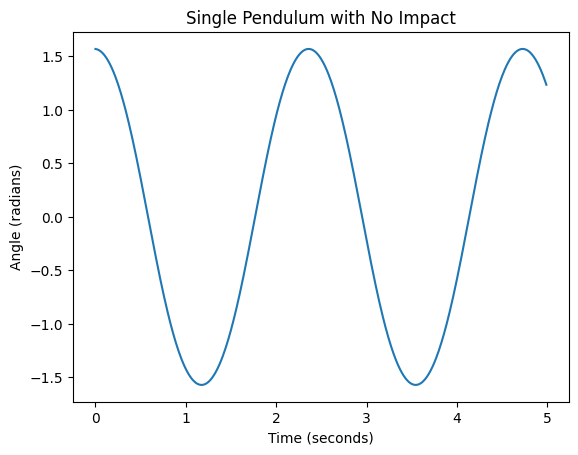

In [59]:
theta_array = traj_array[0]
t_array = np.arange(tspan[0], tspan[1], dt)

# - plot array over time
plt.plot(t_array, theta_array)
plt.xlabel("Time (seconds)")
plt.ylabel("Angle (radians)")
plt.title("Single Pendulum with No Impact")

## Problem 2 (10pts)

Now, time for impact (i.e. don't ignore the vertical wall) ! As shown in the figure above, there is a wall such that the pendulum will hit it when $\theta=0$. Recall that in the course notes, to solve the impact update rule, we have two set of equations:
$$
\begin{aligned}
\frac{\partial L}{\partial \dot{q}} \Big\vert^{\tau^+}_{\tau^-} & = \lambda \frac{\partial \phi}{\partial q} \\
\left[ \frac{\partial L}{\partial \dot{q}}\cdot\dot{q} - L(q,\dot{q}) \right] \Bigg\vert^{\tau^+}_{\tau^-} & = 0
\end{aligned}
$$
    
In this problem, you will need to symbolically compute the following three expressions contained the equations above:
$$\frac{\partial L}{\partial \dot{q}}, \quad \frac{\partial \phi}{\partial q}, \quad \frac{\partial L}{\partial \dot{q}}\cdot\dot{q} - L(q,\dot{q})$$

> Hint 1: The third expression is the Hamiltonian of the system. 
>
> Hint 2: All three expressions can be considered as functions of $q$ and $\dot{q}$. If you have previously defined $q$ and $\dot{q}$ as SymPy's function objects, now you will need to substitute them with dummy symbols (using SymPy's substitute method)
>
> Hint 3: $q$ and $\dot{q}$ should be two sets of separate symbols. 

**Turn in: A copy of code used to symbolically compute the three expressions, also include the outputs of your code, which should be the three expressions (make sure there is no SymPy Function(t) left in your solution output).**

In [98]:
#  - use setup provided in problem 1 - state, lagrangian
phi = theta
lamb = sym.symbols(r'\lambda')
q_sym, qd_sym = sym.symbols(r'q, \dot{q}')
q_subs = {theta: q_sym, thetad: qd_sym}

# - make equation dL/dqdot = lambda*dPhi/dq
dL_dqd = lagrangian1.diff(qd)[0]
lamb_dphi = sym.Matrix([lamb * phi.diff(a) for a in q])[0]
expr_a = dL_dqd.subs(q_subs)
expr_b = lamb_dphi.subs(q_subs)

# - make equation dL/dqd * q -L
expr_c = dL_dqd - lagrangian1
expr_d = expr_c.subs(q_subs)

print("dL_dqdot:")
display(expr_a)
print("Lambda * d(phi)/dq:")
display(expr_b)
print("dL_dqdot - L(q,qdot):")
display(expr_d)


# - define the equations in terms of L, q, and qd dummy vars
# - don't solve the equations yet; just compute the form of them

dL_dqdot:


1.0*R**2*\dot{q}*m

Lambda * d(phi)/dq:


\lambda

dL_dqdot - L(q,qdot):


1.0*R**2*\dot{q}*m - R*m*(0.5*R*\dot{q}**2 + g*cos(q))

## Problem 3 (10pts)

Now everything is ready for you to solve the impact update rules! To solve those equations, you will need to evaluate them right before and after the impact time at $\tau^-$ and $\tau^+$.

> Hint 1: Here $\dot{q}(\tau^-)$ is actually same as the dummy symbol you defined in Problem 2 (why?), but you will need to define new dummy symbol for $\dot{q}(\tau^+)$. That is to say, $\frac{\partial L}{\partial \dot{q}}$ and $\frac{\partial L}{\partial \dot{q}}\cdot\dot{q} - L(q,\dot{q})$ evaluated at $\tau^-$ are those you already had in Problem 2, but you will need to substitute the dummy symbols of $\dot{q}(\tau^+)$ to evaluate them at $\tau^+$. 

Based on the information above, define the equations for impact update and solve them for impact update rules. After solving the impact update solution, numerically evaluate it as a function using SymPy's lambdify method and test it with $\theta(\tau^-)=0.01, \dot{\theta}(\tau^-)=2$.


> Hint 2: In your equations and impact update solutions, there should be NO SymPy Function left (except for internal functions like $\sin$ or $\cos$).
>
> Hint 3: You may wonder where are $q(\tau^-)$ and $q(\tau^+)$? The real question at hand is do we really need new dummy variables for them?
>
> Hint 4: The solution of the impact update rules, which is obtained by solving the equations for the dummy variables corresponds to $\dot{q}(\tau^+)$ and $\lambda$, can be a function of $q(\tau^-)$ or a function of $q(\tau^-)$ and $\dot{q}(\tau^-)$. While $q$ will not be updated during impact, including it now (as an argument in your lambdify function) may help you to combine the function into simulation later.

**Turn in: A copy of code used to symbolically solve for the impact update rules and evaluate them numerically. Also, include the outputs of your code, which should be the test output of your numerically evaluated impact update function.**

In [121]:
# - sub in dummy variables for the functions q(t)and qd(t)
qdtaup, qdtaum = sym.symbols(r'\dot{q}^{\tau+}, \dot{q}^{\tau-}')
qtaup, qtaum = sym.symbols(r'q^{\tau+}, q^{\tau-}')
# qtaup_subs = {q: qtaup, qd:qdtaup}
# qtaum_subs = {q: qtaum, qd:qdtaum}
qtaup_subs = {thetad:qdtaup}
qtaum_subs = {thetad:qdtaum}

#goal is to solve for qd(tau+) and q(tau+) as a function of 
#pre-impact values
impact_a_LHS = dL_dqd.subs(qtaup_subs) - dL_dqd.subs(qtaum_subs)
impact_a = impact_a_LHS - lamb_dphi
impact_b = expr_c.subs(qtaup_subs) - expr_c.subs(qtaum_subs)
impact_b = impact_b.simplify()

expr_mat = sym.Matrix([impact_a, impact_b])
RHS = sym.zeros(len(expr_mat),1)
eqns = sym.Eq(expr_mat, RHS)

sol_vec = [qdtaup, lamb]
solns = sym.solve(eqns, sol_vec, dict=True)

print("Impact expressions to solve:")
display(eqns)

print("Solved:")
# for a in solns:
#     display(a[0])
eqns_solved = []
for i, sol in enumerate(solns):
    
    #do some error checking - if lambda = 0, not valid
    if sol[lamb] == 0:
        print("True")
    else:
        print("False")
        
    for x in list(sol.keys()):
        sol_new = sol[x].simplify()
        eqn_solved = sym.Eq(x, sol_new)
        eqns_solved.append(eqn_solved)

for eq in eqns_solved:
    display(eq)
        
# - find solutions to qdot and lambda
# 	- filter the solutions so that only the ones where lambda is
# 		nonzero are valid
# - 

Impact expressions to solve:


Eq(Matrix([
[                                    1.0*R**2*\dot{q}^{\tau+}*m - 1.0*R**2*\dot{q}^{\tau-}*m - \lambda],
[R**2*m*(-0.5*\dot{q}^{\tau+}**2 + 1.0*\dot{q}^{\tau+} + 0.5*\dot{q}^{\tau-}**2 - 1.0*\dot{q}^{\tau-})]]), Matrix([
[0],
[0]]))

Solved:
0.0
-2.0*R**2*m*(\dot{q}^{\tau-} - 1.0)


Eq(\dot{q}^{\tau+}, \dot{q}^{\tau-})

Eq(\lambda, 0.0)

Eq(\dot{q}^{\tau+}, 2.0 - 1.0*\dot{q}^{\tau-})

Eq(\lambda, 2.0*R**2*m*(1 - \dot{q}^{\tau-}))

## Problem 4 (20pts)

Finally, it's time to simulate the impact! To use impact update rules with our previous simulate function, there two more steps:
1. Write a function called ''impact_condition'', which takes in $s=[q,\dot{q}]$ and returns **True** if $s$ will cause an impact, otherwise the function will return **False**.

> Hint 1 : you need to use the constraint $\phi$ in this problem, and note that, since we are doing numerical evaluation, the impact condition will not be perfect, you will need to catch the change of sign at $\phi(s)$ or setup a threshold to decide the condition.

2. Now, with the ''impact_condition'' function and the numerically evaluated impact update rule for $\dot{q}(\tau^+)$ solved in last problem, find a way to combine them into the previous simulation function, thus it can simulate the impact. Pseudo-code for the simulate function can be found in lecture note 13.

Simulate the system with same parameters and initial condition in Problem 1 for the single pendulum hitting the wall for five times. Plot the trajectory and animate the simulation (you need to modify the animation function by yourself).

**Turn in: A copy of the code used to simulate the system. You don't need to include the animation function, but please include other code (impact_condition, simulate, ets.) used for simulating impact. Also, include the plot and a video for animation. The video can be uploaded separately through Canvas, and it should be in ".mp4" format. You can use screen capture or record the screen directly with your phone.**

## Problem 5 (10pts)

In [ ]:
from IPython.core.display import HTML
display(HTML("<table><tr><td><img src='https://github.com/MuchenSun/ME314pngs/raw/master/tripend_constrained.JPG' width=500' height='450'></table>"))

We will now consider a constrained triple-pendulum system with the system configuration $q=[\theta_1, \theta_2, \theta_3]$. A constraint is such that *x coordinate* of the third pendulum (i.e. $m_3$) ONLY can not be smaller than 0 -- there exist a vertical wall high enough for third pendulum impact. Note that there is no constraint on *y coordinate* -- the top ceiling is infinitely high!

Similar to Problem 2, symbolically compute the following three expressions contained the equations above:
$$\frac{\partial L}{\partial \dot{q}}, \quad \frac{\partial \phi}{\partial q}, \quad \frac{\partial L}{\partial \dot{q}}\cdot\dot{q} - L(q,\dot{q})$$ 

Use $m_1=m_2=m_3=1$ and $R_1=R_2=R_3=1$ as numerical values in the equations (i.e. **do not** define $m_1, m_2, m_3, R_1, R_2, R_3$ as symbols).

> Hint 1: As before, you will need to substitute $q$ and $\dot{q}$ with dummy symbols.

**Turn in: Include the code used to symbolically compute the three expressions, as well as code outputs - the resulting three expressions. Make sure there is no SymPy Function(t) left!**

## Problem 6 (10pts)

Similar to Problem 3, now you need to define dummy symbols for $\dot{q}(\tau^+)$, define the equations for impact update rules. Note that you don't need to solve the equations in this problem - in fact it's very time consuming to solve the analytical solution, and we will use a trick to get around it later!

**Turn in: Include a copy of the code used to define the equations for impact update and the code output (i.e. print out of the equations).**

## Problem 7 (15pts)

Since solving the analytical symbolic solution of the impact update rules for the triple-pendulum system is too slow, here we will solve it along within the simulation. The idea is, when the impact happens, substitute the numerical values of $q$ and $\dot{q}$ at that moment into the equations you got in Problem 6, thus you will just need to solve a set equations with most terms being numerical values (which is very fast).

The first thing is to write a function called "impact\_update\_triple\_pend". This function at least takes in the current state of the system $s(t^-) = [q(t^-), \dot{q}(t^-)]$ or $\dot{q}(t^-)$, inside the function you need to substitute in $q(t^-)$ and $\dot{q}(t^-)$, solve for and return $s(t^+) = [q(t^+), \dot{q}(t^+)]$ or $\dot{q}(t^+)$ (which should be numerical values now). This function will replace lambdify, and you can use SymPy's "sym.N()" or "expr.evalf()" methods to convert SymPy expressions into numerical values. Test your function with $\theta_1(\tau^-) = \theta_2(\tau^-) = \theta_3(\tau^-) = 0$ and $\dot{\theta}_1(\tau^-) = \dot{\theta_2}(\tau^-) = \dot{\theta_3}(\tau^-) = -1$. 

**Turn in: A copy of your "impact_update_triple_pend" function, and the test result of your function.**

## Problem 8 (15pts)

Similar to the single-pendulum system, you will still want to implement a function named "impact\_condition\_triple\_pend" to indicate the moment when impact happens. Again, you need to use the constraint $\phi$. After obtaining the impact condition function, simulate the triple-pendulum system with impact for $t\in[0,2], dt=0.01$ with initial condition $\theta_1=\frac{\pi}{3}, \theta_2=\frac{\pi}{3}, \theta_3=-\frac{\pi}{3}$ and $\dot{\theta}_1=\dot{\theta}_2=\dot{\theta}_3=0$. Plot the simulated trajectory versus time and animate your simulated trajectory.

> Hint 1: You will need to modify the simulate function!

**Turn in: A copy of code for the impact update function and simulate function, as well as code output including the plot of simulated trajectory and the animation. The video should be uploaded separately from the .pdf file through Canvas, and it should be in ".mp4" format. You can use screen capture or record the screen directly with your phone.**

## Problem 9 (5pts)

Compute and plot the Hamiltonian of the simulated trajectory for the triple-pendulum system with impact.

**Turn in: A copy of code used to compute the Hamiltonian, also include the code output, which should the plot of the Hamiltonian versus time.**